# Investigating Medical Appointment No Shows in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Introduction


This research report will try to determine the factors that may influence a patient's decision to show up for a medical appointment or not (dependant variable). The dataset we will be using to perform the investigation consists of 110,527 medical appointments scheduled at various medical centres in Brazil between 10 November 2015 and 08 June 2016. The appointment dates spanned less than two months from 29 April 2016 to 08 June 2016. We will investgate whether certain characteristics (independant variables) captured in the data can predict if a patient will show up.

There are 14 columns in total that categorise a number of factors. They are summarised below:

        01 PatientId: Unique patient identifier

        02 AppointmentID: Unique code for each appointment

        03 Gender: Lists whether a patient is male (M) or female (F)

        04 ScheduledDay: The date that an appointment is made

        05 AppointmentDay: The date the patient is expected to show up for an appointment

        06 Age: Age of each patient

        7 Neighbourhood: The area where the appointment takes place

        8 Scholarship: Indicates whether a patient is enrolled in the Brazilian welfare program or not

        9 Hipertension: Indicates whether a patient suffers from hypertension or not

        10 Diabetes: Indicates whether a patient suffers from diabetes or not

        11 Alcoholism: Indicates whether a patient suffers from alcoholism or not

        12 Handcap: The number of handicaps a patient has

        13 SMS_received: Indicates whether a patient received an SMS or not

        14 No-show: Indicates whether a patient showed up for the appointment or not. 'No' means that a patient did show up, while 'Yes' means that a patient did not show up

    
The analysis will be limited to investigating the following variables and their effect on the 'No-show' variable:

        - The gender of a patient

        - The number of days between the scheduling of an appointment and the actual appointment (AppointmentDay - ScheduledDay)

        - The number ailments (Hypertension + Diabetes + Alcoholism + Handicap)


The analysis will seek to answer the following questions:

        1. Which gender is more likely to miss an appointment?

        2. Does the number of days from when a patient schedules an appointment to the actual appointmnet date affect whether s/he shows up?
        
        3. How does the total number of ailments affect a patients decision to miss an appointment

In [169]:
# import packages to be used in analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

<a id='wrangling'></a>
# Data Wrangling

In this section of the report, data will be loaded, checked for cleanliness, and then trimed and cleaned to be prepared for analysis.

### General Properties

In [170]:
# load dataset and inspect data
# the csv file has been renamed for ease of use

df = pd.read_csv('no_shows.csv')
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Upon initial inspection of the data, I have decided to drop the "PatientId" and "AppointmentID" as I believe they will not be relavant for the rest of this analysis.

I will rename the columns so that they are all lowercase to make it easier to be consistent with the rest of the code. I will also replace the "-" in "No-show" to an underscore ("_").

"Hipertension" and "Handcap" to be renamed to the correct English spellings.

In [171]:
# find the dimesions of the dataframe
df.shape

(110527, 14)

There are currently 110,527 rows and 14 columns present in the data.

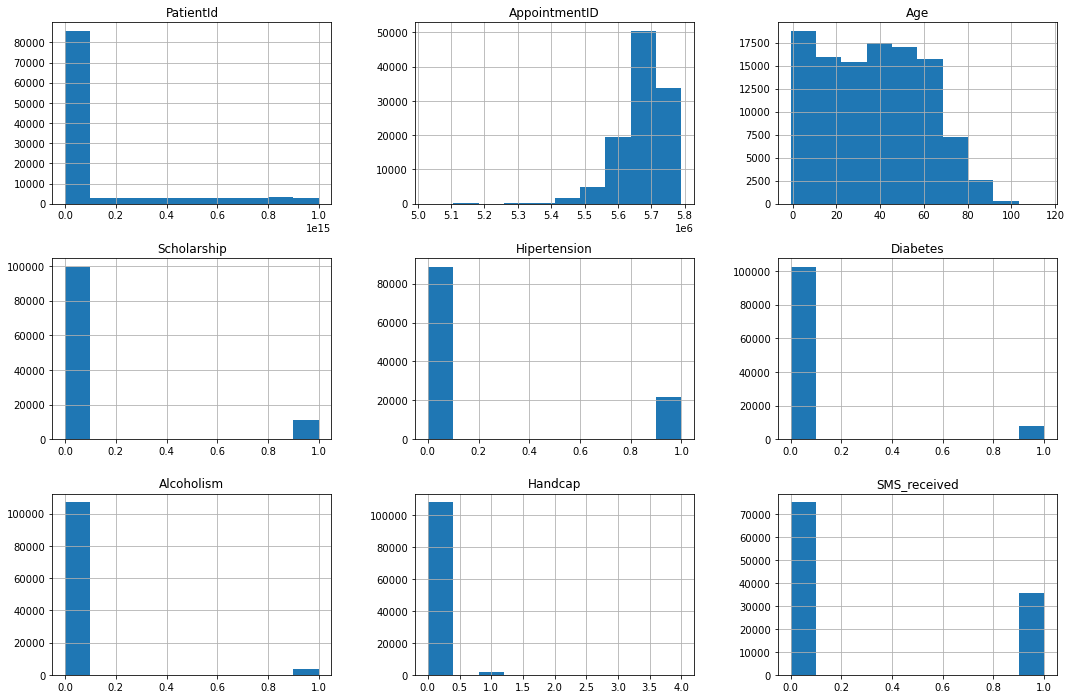

In [172]:
# Show a distribution of the data
df.hist(figsize =(18,12));

In [173]:
# get summary statistics of the data
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


#### Key findings

The minimum value of -1 in the 'Age' column of appears to be an error as you cannot have a negative age. We could theorise that the data is referring to an unborn child. However, if that was true, it ia more likely that the the mother of an unborn child would be the patient. I will investigate the frequency of the negative ages to determine if is significant and deal with it accordingly.


Almost 10% of patients have scholarships

Almost 20% of patients suffer from hypertension

7% have diabetes

3% alcoholism

2% handicaped

In [174]:
# check how many rows have an age less than 0
df.query('Age <0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


Row 99832 is only entry with a negative age.

It appears to be an error as a person's age cannot be negative. I can comfortably drop this row as it makes up an insignifant part of the dataset.

In [175]:
# get information about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


1. The number of rows seems is consistent for all the columns, There does not appear to be any null values present in the data.

2. "ScheduledDay" and "AppointmentDay" are stored as strings. They should converted to datetime objects.

3. [Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received] appear to binary entries. I will verify how many unique values are present.


In [176]:
# 1. confirm that there are no null values present in the data

df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

There are no null values present in the data.

In [177]:
# 2. inspect "ScheduledDay" and "AppointmentDay" to confirm that converting to a datetime object would be more applicable

print(df['ScheduledDay'].head(3))
print(df['AppointmentDay'].head(3))

0    2016-04-29T18:38:08Z
1    2016-04-29T16:08:27Z
2    2016-04-29T16:19:04Z
Name: ScheduledDay, dtype: object
0    2016-04-29T00:00:00Z
1    2016-04-29T00:00:00Z
2    2016-04-29T00:00:00Z
Name: AppointmentDay, dtype: object


"ScheduledDay" and "AppointmentDay" have been successfully converted to datetime objects.

In [178]:
# 3. Check for unique values [Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received] 

columns = ['Scholarship', 'Hipertension','Diabetes','Alcoholism', 'Handcap', 'SMS_received','No-show']
for c in columns:
    print(c,"-",df[c].unique())
    

Scholarship - [0 1]
Hipertension - [1 0]
Diabetes - [0 1]
Alcoholism - [0 1]
Handcap - [0 1 2 3 4]
SMS_received - [0 1]
No-show - ['No' 'Yes']


We  can confirm that [Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received] only have two unique values (0 and 1) so we can confirm that they are binary entries.


Handcap has five unique values and upon further research I have found that the creater of the dataset confirmed that "Handcap" refers to the number of disabilities applicable to each patient. For example if a person is blind and deaf, the number 2 would be recorded.

Source: https://www.kaggle.com/datasets/joniarroba/noshowappointments/discussion/29699?search=handcap

In [179]:
#check data for duplicate entries

df.duplicated().sum()

0

There are no dupliacted rows.

### Data Cleaning (Replace this with more specific notes!)

In [180]:
# make a copy of the data which will then be cleaned and further analysed
df_clean = df

In [181]:
# drop PatientId and AppointmentID from the data
df_clean.drop(['PatientId','AppointmentID', 'Neighbourhood'], axis =1, inplace = True)
df_clean.head(1)

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No


PatientId and AppointmentID were dropped from the data as they will not be relevant to answering the research questions.

In [182]:
# replace dash with underscore and make all anmes lowercase
#df_clean.rename(str.lower, axis = 'columns')

df_clean.rename(columns=lambda x: x.lower().replace("-", "_"), inplace= True)
df_clean.rename(columns = {'scheduledday':'scheduled_day','appointmentday':'appointment_day','hipertension':'hypertension','handcap':'handicap'}, inplace= True)
df_clean.head(1)

# source: Case Study 2 (6. Cleaning Column Labels)

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No


Column names were renamed to make the data easier to read and handle the data.

In [183]:
# drop row where age is less than 0
df_clean.drop(99832, inplace= True)
# check that the row has been successfully dropped
df_clean.query('age < 0')

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show


All negative ages have been removed.

In [184]:
# Covert strings to datetime
df_clean['scheduled_day']= pd.to_datetime(df_clean['scheduled_day'])
df_clean['appointment_day']= pd.to_datetime(df_clean['appointment_day'])

In [185]:
# Confirm that dates have been successfully converted
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   gender           110526 non-null  object             
 1   scheduled_day    110526 non-null  datetime64[ns, UTC]
 2   appointment_day  110526 non-null  datetime64[ns, UTC]
 3   age              110526 non-null  int64              
 4   scholarship      110526 non-null  int64              
 5   hypertension     110526 non-null  int64              
 6   diabetes         110526 non-null  int64              
 7   alcoholism       110526 non-null  int64              
 8   handicap         110526 non-null  int64              
 9   sms_received     110526 non-null  int64              
 10  no_show          110526 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(7), object(2)
memory usage: 10.1+ MB


I converted "ScheduledDay" and "AppointmentDay" into datetime objects to enable me to calculate the difference between the date an appointment is scheduled and the actual appointment date.

In [186]:
# calculate the number of days between 'appointment day and 'scheduled day'
days_to_appointment = df_clean['appointment_day'] - df_clean['scheduled_day']
days_to_appointment.head()

0   -1 days +05:21:52
1   -1 days +07:51:33
2   -1 days +07:40:56
3   -1 days +06:30:29
4   -1 days +07:52:37
dtype: timedelta64[ns]

In [187]:
# Describe the data
days_to_appointment.describe()

count                        110526
mean      9 days 17:08:42.047952517
std      15 days 05:51:31.240428096
min               -7 days +10:10:40
25%               -1 days +15:41:32
50%                 3 days 11:22:33
75%         14 days 07:41:37.750000
max               178 days 13:19:01
dtype: object

I was able to calculate the number of days between the schedule date and the appointment date, however the data is not in a usable format.

The calculated data also has negative days, which is not possible.

In [188]:
# convert number of days to int and add the data to a new column
df_clean['days_to_appointment'] = (days_to_appointment / np.timedelta64(1, 'D')).astype(int)
df_clean['days_to_appointment'].head()

#source: https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe

0    0
1    0
2    0
3    0
4    0
Name: days_to_appointment, dtype: int32

'days_to_appoitnment' converted to an int object to make the data easier to manipulate.

In [189]:
# identify the which rows contain negative days
df_clean.query('days_to_appointment < 0')

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_to_appointment
27033,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,0,0,0,0,1,0,Yes,-1
55226,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,0,0,0,0,1,0,Yes,-1
64175,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,0,0,0,0,0,0,Yes,-1
71533,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,0,0,0,0,0,0,Yes,-6
72362,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,0,0,0,0,0,0,Yes,-1


We find that 5 rows have negative 'days_to_appointment'. We will assume that 'scheduled_day' and 'appointment_day' for the respective entries were mistakenly swapped around. This can be resolved by forcing all values to be positive

In [190]:
# make all values for 'days_to_appointment' positive
df_clean['days_to_appointment'] = df_clean['days_to_appointment'].abs()
# confirm that values have been made positive
df_clean['days_to_appointment'].describe()

count    110526.000000
mean          9.532915
std          15.027724
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_to_appointment, dtype: float64

In [191]:
# count the number of values below 0 days
df_clean.query('days_to_appointment < 0')['days_to_appointment'].count()

0

The previous two cells confirm that the negative values have been made positive

In [192]:
# view sample of cleaned data
df_clean.head()

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_to_appointment
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,No,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,No,0
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,No,0
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,No,0
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,No,0


In [193]:
# show the final dimensions of the cleaned data
df_clean.shape

(110526, 12)

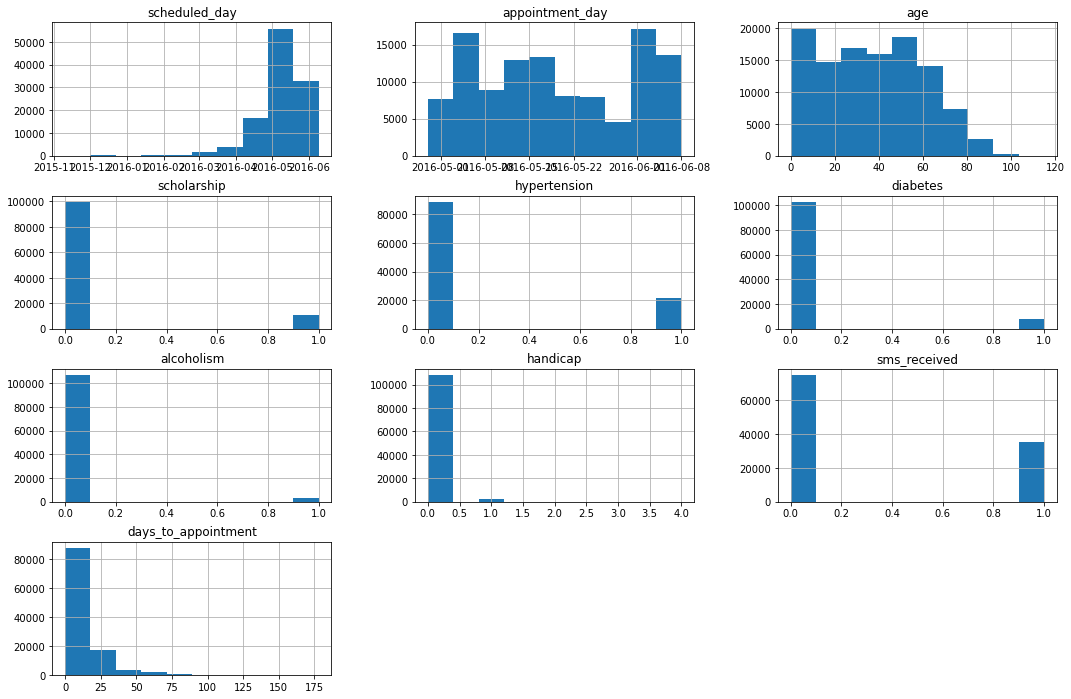

In [194]:
# Show a distribution of the data
df_clean.hist(figsize=(18,12));

The has now been cleaned.

There are now 110,526 rows and 12 columns present in the data that will be further analyzed.

Final distributions presented.

<a id='eda'></a>
# Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### 1. Which gender is more likely to miss an appointment?

In [195]:
# Create a new dataframe to answer question 1
df_gender = df_clean

In [196]:
# Calculte the number of patients that show up for appointments
show = df_clean.query('no_show == "No"').value_counts().sum()
show

88207

In [197]:
# Calculte the number of patients that show up for appointments
no_show = df_clean.query('no_show == "Yes"').value_counts().sum()
no_show

22319

In [198]:
# Calculate the proportion of patients that show up
pct_show = np.round(show / (show + no_show) * 100,2)
pct_show

79.81

In [199]:
# Calculate the proportion of patients that don't show up
pct_no_show = np.round(no_show / (show + no_show) * 100,2)
pct_no_show

20.19

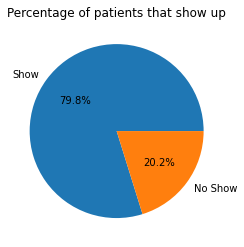

In [200]:
# Plot pie chart showing proportion of no shows and patients that do show
from turtle import title

fig1, ax = plt.subplots()
ax.pie([pct_show, pct_no_show], labels = ('Show', 'No Show'), autopct='%1.1f%%')
plt.title('Percentage of patients that show up')
plt.rcParams["figure.figsize"] = (14,7) 

# Source: https://stackoverflow.com/questions/61239061/how-do-you-resize-a-bar-chart-created-using-matplotlib 
# Source: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
# Source: https://www.w3resource.com/graphics/matplotlib/piechart/matplotlib-piechart-exercise-2.php

We establish that 20.19% of all patients don't show up for appoints. We will use this as a benchmark for the data.

The next step is to establish whether gender has an effect on this statistic

In [201]:
# Calculate the number of female patients
female = df_gender.query('gender == "F"')['gender'].count()
female

71839

There are 71,839 female patients

In [202]:
# Calculate the number of male patients
male = df_gender.query('gender == "M"')['gender'].count()
male

38687

There are 38,687 male patients

In [203]:
# Calculate the total number of patients. Make sure that it matches the dimensions calculated earlier
total_app = female + male
total_app

110526

The total matches the number of rows in the data. We can be confident that all the values have been accounted for.

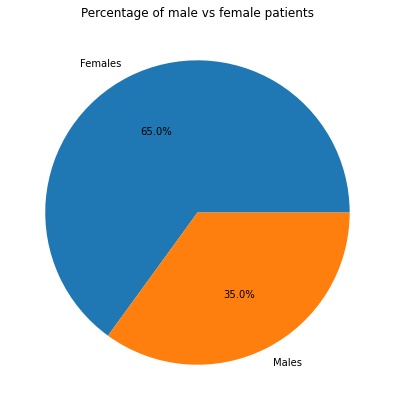

In [204]:

fig1, ax = plt.subplots()
ax.pie([female, male], labels = ('Females', 'Males'), autopct='%1.1f%%')
plt.title('Percentage of male vs female patients')
plt.rcParams["figure.figsize"] = (14,7) 

Females account for 65% of all patients

(71839, 38687)

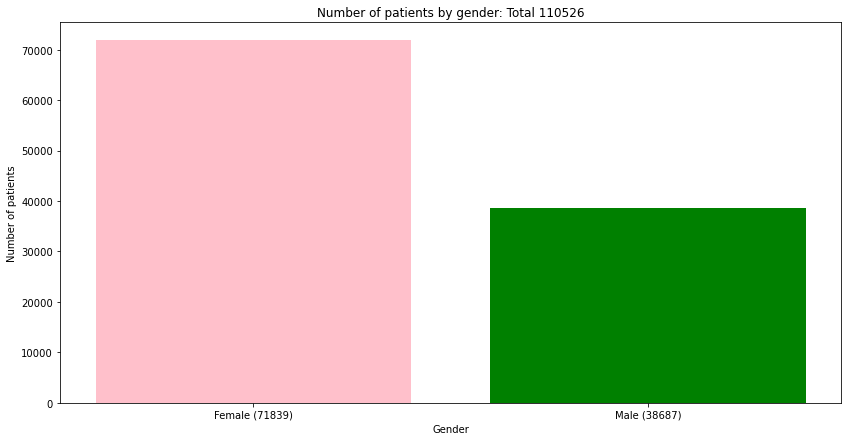

In [205]:
# Plot the number of female vs male patients
gender_heights = [female, male]
gender_labels = ['Female ({})'.format(female), 'Male ({})'.format(male)]
plt.bar([1,2],gender_heights, tick_label = gender_labels, color=['pink','green'])

# Chart title
plt.title('Number of patients by gender: Total {}'.format(total_app))
# Label x-axis
plt.xlabel('Gender')
# Label y-axis
plt.ylabel('Number of patients');
# Resize chart
plt.rcParams['figure.figsize'] = (14,7) 
# Show total number for females and for males
female, male

The chart above shows that there is almost double the number of female patients than there are males. 

We can't make any inferences on whether gender has an impact on whether a patient shows based on this result. We will need to investigate further by determining what proportion of each gender misses its appointments.

In [206]:
# Calculate the number of females that didn't show up for their appointments
female_no_show = df_gender.query('no_show == "Yes"').query('gender == "F"')['gender'].count()
female_no_show

14594

There are 14,594 female patients that missed appointments

In [207]:
# Calculate the number of males that didn't show up for their appointments
male_no_show = df_gender.query('no_show == "Yes"').query('gender == "M"')['gender'].count()
male_no_show

7725

There are 7,725 male patients that missed appointments

In [208]:
# Percentage of females that didn't show up
pct_no_show_f = np.round(female_no_show / female * 100,2)
pct_no_show_f

20.31

In [209]:
# Percentage of males that didn't show up
pct_no_show_m = np.round(male_no_show / male * 100,2)
pct_no_show_m

19.97

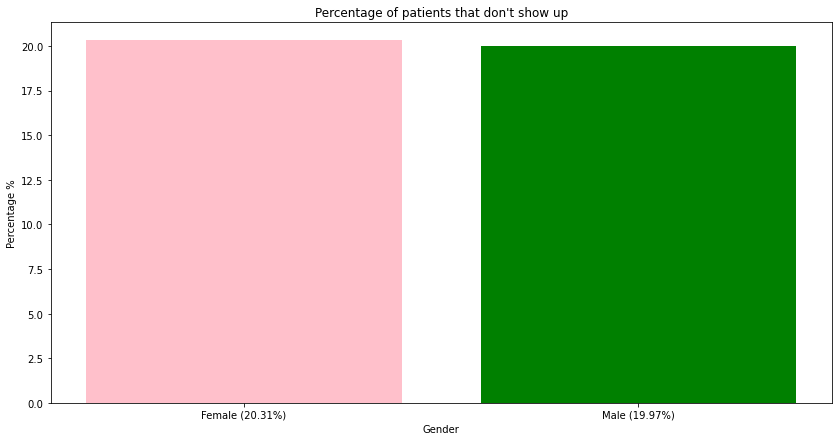

In [210]:
# Plot the proportion of females vs male that don't show up for appointments
show_heights = [pct_no_show_f, pct_no_show_m]
gender_labels = ['Female ({}%)'.format(pct_no_show_f), 'Male ({}%)'.format(pct_no_show_m)]
plt.bar([1,2],show_heights, tick_label = gender_labels, color=['pink','green'])
# Chart title
plt.title("Percentage of patients that don't show up")
# Label x-axis
plt.xlabel('Gender')
# Label y-axis
plt.ylabel('Percentage %');
# Resize chart
plt.rcParams['figure.figsize'] = (14,7)

#### 1. Conclusion

20.19% of all patients did not show up for the appointments (benchmark)

20.31% of female patients don't show up

19.97% of male patients don't show up

From the results above we can see that the proportion of males and females that miss their appointments is very similar to the benchmark (20.19%). 

Based on this result, we can theorise that a patient's gender may not significantly impact whether or not a patient shows up for an appointment. 

The likelihood of a female missing an appointment is similar to that of a male. Based on this limited analysis, it appears that gender may not determine whether a patient misses an appointment.

Despite this we cannot rule out the possibilty of a relationship existing between gender and not showing up without deeper analysis.

### 2. Does the number of days from when a patient schedules an appointment to the actual appointment date affect whether he/she shows up?

In [211]:
# Create new dataframe to answer question 2
df_days = df_clean

In [212]:
# Descriptive statistics for 'days_to_appointment'
df_days['days_to_appointment'].describe()

count    110526.000000
mean          9.532915
std          15.027724
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_to_appointment, dtype: float64

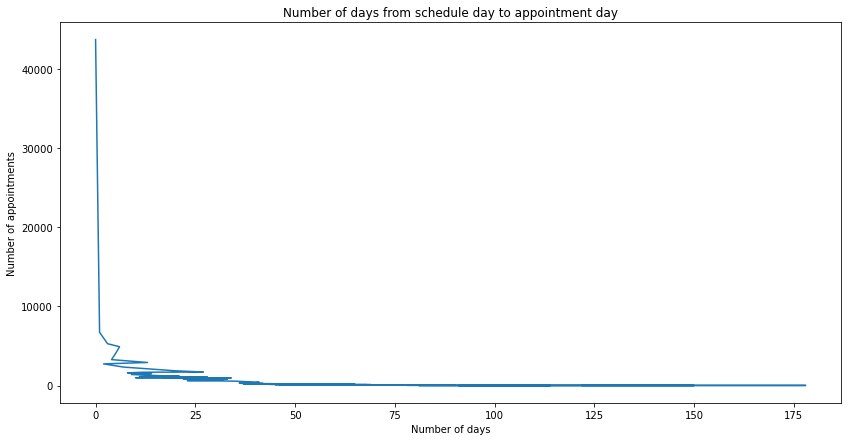

In [213]:
# Plot the distribution of appointments against the number of days between the schedule and appointment day
df_days['days_to_appointment'].value_counts().plot()
plt.title("Number of days from schedule day to appointment day")
plt.xlabel('Number of days')
plt.ylabel('Number of appointments');
# resize chart
plt.rcParams['figure.figsize'] = (10,5) 

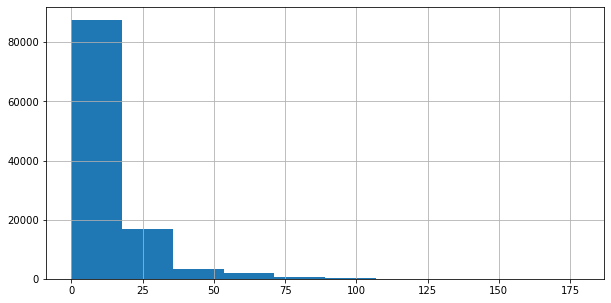

In [214]:
# Plot histogram
df_days['days_to_appointment'].hist();
# resize chart
plt.rcParams['figure.figsize'] = (20,10)

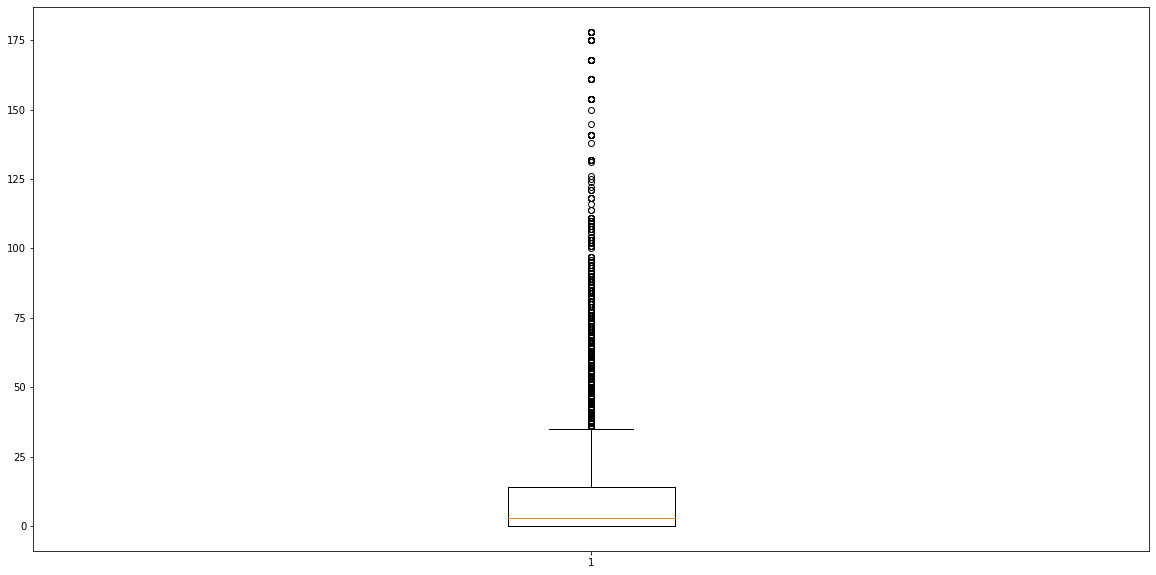

In [215]:
# Plot boxplot to visulaise outliers
plt.boxplot(df_days['days_to_appointment']);
# resize chart
plt.rcParams['figure.figsize'] = (12,6)

In [216]:
# Calculate number of appointments after 30 days
days_30 = df_days.query('days_to_appointment >30').value_counts().sum()
days_30

9706

In [217]:
# Percentage of appointments that take place after 30 days
np.round(days_30 / total_app * 100,2)

8.78

#### Results of descriptive statistics, line chart and boxplot

It looks like significant number of appointments are scheduled on the same day, with the data heavily skewed to the right.

The number of days to an appointment range from 0 days to 178 days, with 75% of all of appointments taking place within 14 days. 

The average wait time is 9.53 days, with only 8.78% of appointments taking place after 30 days of being scheduled.



In [218]:
# Create catergories for 'days_to_appointment'
bins=[-1, 1, 3, 14, 30,178]

Bins calculated according to the distribution in the descriptive statistics of this data

I have included the 30 day mark because that is the point where the number of appointments start to drastically slow down


In [219]:
# Create new column for new range
df_days['wait_time'] = pd.cut(df_days['days_to_appointment'], bins=bins)

In [220]:
# Create new dataframe for show/no show grouped by 'days_to_appointment
wait = df_days.groupby(['wait_time','no_show']).size().unstack()
wait

no_show,No,Yes
wait_time,,
"(-1, 1]",45993,4511
"(1, 3]",6152,1875
"(3, 14]",18400,7349
"(14, 30]",11161,5379
"(30, 178]",6501,3205


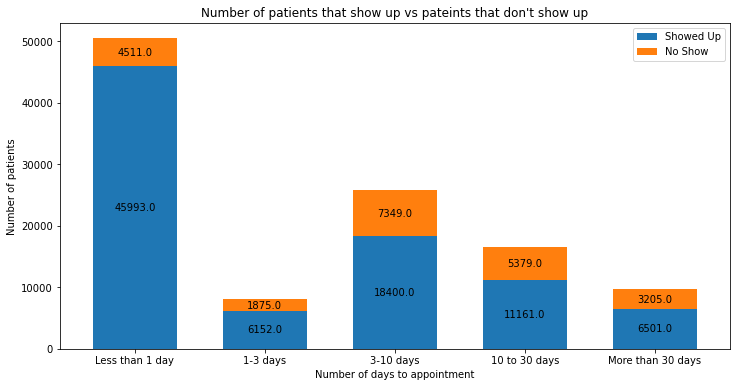

In [221]:
# Create labels for bars
day_range = ['Less than 1 day', '1-3 days','3-10 days', '10 to 30 days', 'More than 30 days']
# Rename columns 
wait.rename(columns = {'Yes':'No Show', 'No':'Showed Up'}, inplace = True)

# Plot stsacked chart
ax = wait.plot(kind ='bar', stacked = True, width = 0.65)

# Label individual bars
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = height
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center',    
            va='center')
    

# Set Tick labels
ax.set_xticklabels(day_range,rotation='horizontal')
ax.set_title("Number of patients that show up vs pateints that don't show up")
ax.set_xlabel('Number of days to appointment')
ax.set_ylabel('Number of patients')
# Format legend
ax.legend(title= None,loc='upper right')
# Resize chart
plt.rcParams["figure.figsize"] = (14,7)

# source: https://pythonguides.com/stacked-bar-chart-matplotlib/

We want to see the number of patients that and show up and those that don't show up for each time period.

Almost half of all appointments take place on the same day that they are scheduled.

The number of appointments drop off between 1 to 3 days and then increase between 3 to 14 days before decreasing for the rest of the periods.

To further investigate whether there is a relationship between the number of days a patient waits for an appointment and whether or not they show up or not, we will have compute the rate of no shows for the range of days.

In [222]:
# Create a new dataframe to calculate the percentage of no shows
wait_pct = wait
wait_pct

no_show,Showed Up,No Show
wait_time,,
"(-1, 1]",45993,4511
"(1, 3]",6152,1875
"(3, 14]",18400,7349
"(14, 30]",11161,5379
"(30, 178]",6501,3205


In [223]:
# New column / calculate percentage of patients that show up for each range of days
wait_pct['show_%'] = np.int0(np.round(wait['Showed Up'] / (wait['No Show'] + wait['Showed Up'])*100,0))
# New column / calculate percentage of patients that don't show up for each range of days
wait_pct['no_show_%'] = np.int0(np.round(wait['No Show'] / (wait['No Show'] + wait['Showed Up'])*100,0))
wait_pct

no_show,Showed Up,No Show,show_%,no_show_%
wait_time,,,,
"(-1, 1]",45993,4511,91,9
"(1, 3]",6152,1875,77,23
"(3, 14]",18400,7349,71,29
"(14, 30]",11161,5379,67,33
"(30, 178]",6501,3205,67,33


In [224]:
# Drop 'Showed Up' and 'No Show' colums
wait_pct_final = wait_pct.drop(['Showed Up','No Show'],axis=1)
wait_pct_final

no_show,show_%,no_show_%
wait_time,,
"(-1, 1]",91,9
"(1, 3]",77,23
"(3, 14]",71,29
"(14, 30]",67,33
"(30, 178]",67,33


The columns have been dropped to allow us to focus on the percentage of patients that show up versus those that do not.

I have saved the result as a new dataframe as I find the inplace function to be messy when trying to review previous cells

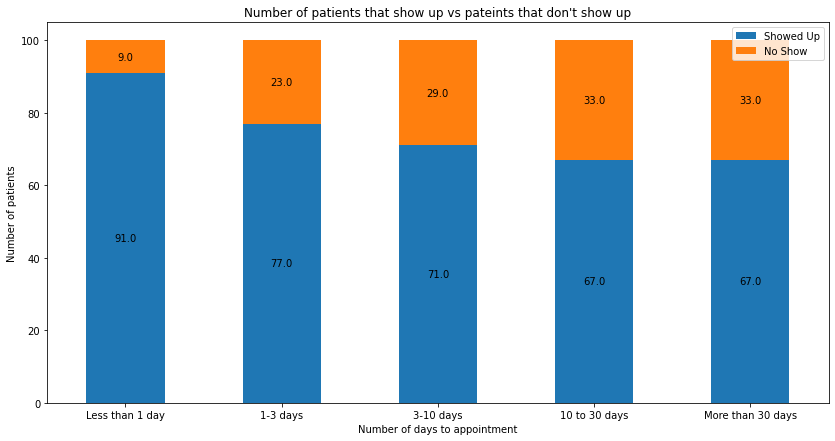

In [225]:
# Rename coumns
wait_pct_final.rename(columns = {'no_show_%':'No Show', 'show_%':'Showed Up'}, inplace = True)
# Plot stacked chart
ax = wait_pct_final.plot(kind='bar', stacked=True)

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = height
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center',  
            va='center')
    
# Set Tick labels
ax.set_xticklabels(day_range,rotation='horizontal')
ax.set_title("Number of patients that show up vs pateints that don't show up")
ax.set_xlabel('Number of days to appointment')
ax.set_ylabel('Number of patients')
# Format legend
ax.legend(title= None,loc='upper right')
# Resize chart
plt.rcParams["figure.figsize"] = (14,7)


# source: https://pythonguides.com/stacked-bar-chart-matplotlib/

Text(0.5, 1.0, 'Relationship between the number of days before an appointment & patients showing up')

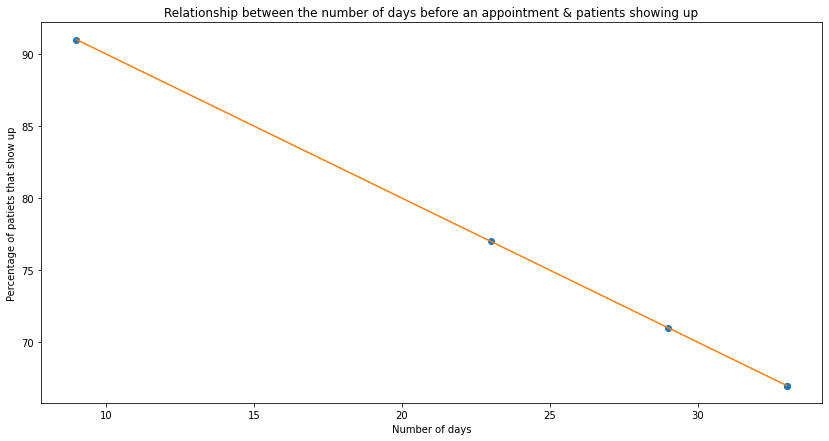

In [226]:
# Scatter plot 

# X-axis
x = wait_pct_final['No Show']
# Y-axis
y = wait_pct_final['Showed Up']
# calculate line of best fit
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x + b)
#plt.scatter(x, y)
plt.xlabel('Number of days')
plt.ylabel('Percentage of patiets that show up')
plt.title('Relationship between the number of days before an appointment & patients showing up')

#### 2. Conclusion

The results above show that patients that wait less than a day between scheduling an appointment and the date of the actual of the appointment are more likely to show up, with more than 90% showing up when they schedule an appointment for the same day.

Patients appear to be more likely to miss an appointment the longer they wait

There appears to be a strong negative correlation between the variables

However, we cannot infer that a relationship exists between the variable without taking other variables into account and performing more detailed analysis. Correlation does not equal causation.

### 3. How does the total number of ailments affect a patient's decision to miss an appointment?

In [228]:
# Create new dataframe to deal exclusively with patient ailments
cols = ['gender','scheduled_day', 'appointment_day','age','scholarship','sms_received','days_to_appointment', 'wait_time']
df_ailm = df_clean.drop(cols, axis =1)
df_ailm.head()

,hypertension,diabetes,alcoholism,handicap,no_show
0,1,0,0,0,No
1,0,0,0,0,No
2,0,0,0,0,No
3,0,0,0,0,No
4,1,1,0,0,No


In [229]:
# Make all values greater than 1 equal 1
df_ailm['handicap'] = np.where(df['handicap'] > 1, 1, df['handicap'])

# https://sparkbyexamples.com/pandas/pandas-replace-values-based-on-condition/

The 'handicap' column has 4 unique values but I only want to test for the presence of a handicap instead of the number of handicaps a patient may have. I made all the values above 1 equal 1 so that I can have binary responses to match the other ailments.

The utlimate goal is test what combination of the recorded ailments lead to more patients not showing.

In [230]:
# Confirm that there are no value above 1
df_ailm.query('handicap > 1')

,hypertension,diabetes,alcoholism,handicap,no_show


In [231]:
# Create a column adding up the number of ailments for each patient
df_ailm['num_ailm'] = df_ailm['hypertension'] + df_ailm['diabetes'] + df_ailm['alcoholism']+ df_ailm['handicap']
df_ailm['num_ailm'].describe()

count    110526.000000
mean          0.319789
std           0.625349
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: num_ailm, dtype: float64

In [232]:
# Group data by the number of total ailments as well whether a patient shows up
df_ailm.groupby('num_ailm')['no_show'].value_counts()

num_ailm  no_show
0         No         66511
          Yes        17603
1         No         14874
          Yes         3249
2         No          6290
          Yes         1368
3         No           523
          Yes           95
4         No             9
          Yes            4
Name: no_show, dtype: int64

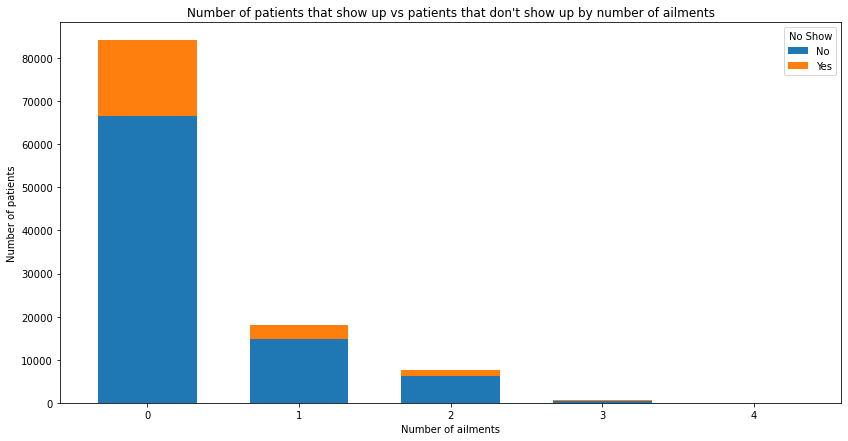

In [233]:
# Plot the number of patients that show up vs patients that don't show up by number of ailments

df_ailm.groupby(['num_ailm','no_show']).size().unstack().plot(kind ='bar', stacked = True, width = 0.65)

plt.xticks(rotation = 0)
plt.title("Number of patients that show up vs patients that don't show up by number of ailments")
plt.xlabel('Number of ailments')
plt.ylabel('Number of patients')
# Format legend
plt.legend(title = 'No Show',loc='upper right')
# Resize chart
plt.rcParams["figure.figsize"] = (14,7)

# source: https://pythonguides.com/stacked-bar-chart-matplotlib/

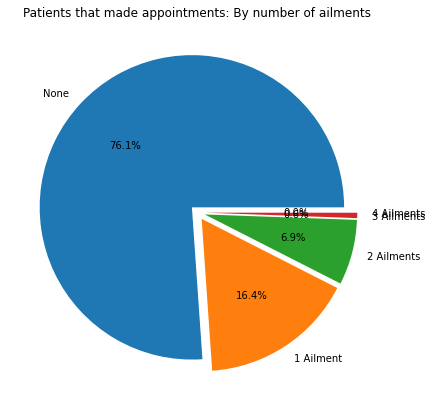

In [234]:
# Plot the proportion of patients that have a certain number of ailments
label = ['None', '1 Ailment', '2 Ailments', '3 Ailments', '4 Ailments']
ax = df_ailm.groupby('num_ailm')['num_ailm'].value_counts()
ax.plot(kind = 'pie', labels = label, autopct='%1.1f%%', explode = ax.value_counts()*0.05)
plt.title('Patients that made appointments: By number of ailments')
plt.ylabel('')
plt.rcParams["figure.figsize"] = (14,7) 

# Source: https://www.pythoncharts.com/matplotlib/pie-chart-matplotlib/

76.1% of patients have no ailments

16.4% of patients have at least one ailment

6.9% of patients have two ailments

Less than 1% of patients have three or more ailments

In [235]:
# Number of patients that show up grouped by the number of their ailments
df_ailm_no = df_ailm.query('no_show == "No"').groupby('num_ailm')['num_ailm'].count()
df_ailm_no

num_ailm
0    66511
1    14874
2     6290
3      523
4        9
Name: num_ailm, dtype: int64

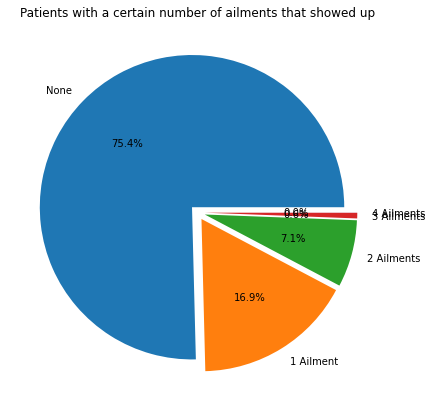

In [236]:
# Plot the proportion of patients that have a certain number of ailments and showed up
label = ['None', '1 Ailment', '2 Ailments', '3 Ailments', '4 Ailments']
df_ailm_no.plot(kind = 'pie', labels = label, autopct='%1.1f%%', explode = df_ailm_no.value_counts()*0.05)
plt.title('Patients with a certain number of ailments that showed up')
plt.ylabel('')
plt.rcParams["figure.figsize"] = (14,7) 

# Source: https://www.pythoncharts.com/matplotlib/pie-chart-matplotlib/

The distribution of patients that showed up catergorised by ailment is very close to the distribution of the total number of patients that make appointments.

In [237]:
# Number of patients that show up grouped by the number of their ailments
df_ailm_yes = df_ailm.query('no_show == "Yes"').groupby(['num_ailm'])['num_ailm'].count()
df_ailm_yes

num_ailm
0    17603
1     3249
2     1368
3       95
4        4
Name: num_ailm, dtype: int64

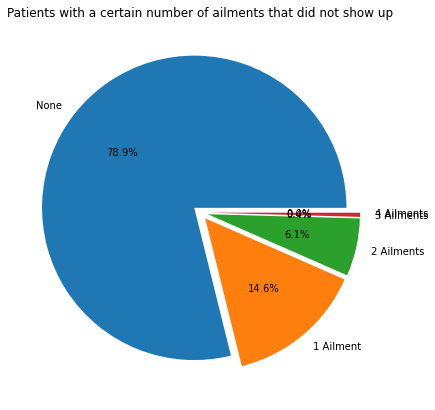

In [238]:
# Plot the proportion of patients that have a certain number of ailments and didn't show up
df_ailm_yes.plot(kind = 'pie', labels = label, autopct='%1.1f%%', explode = df_ailm_no.value_counts()*0.05)
plt.title('Patients with a certain number of ailments that did not show up')
plt.ylabel('')
plt.rcParams["figure.figsize"] = (14,7)

# Source: https://www.pythoncharts.com/matplotlib/pie-chart-matplotlib/

It appears that the number of patients with no ailments that do not show up make up is slighlty higher proportion of the total patients that do not show up compared to the previous results.

It could be that patients with ailments are less likely to miss their appointments because they need the care.

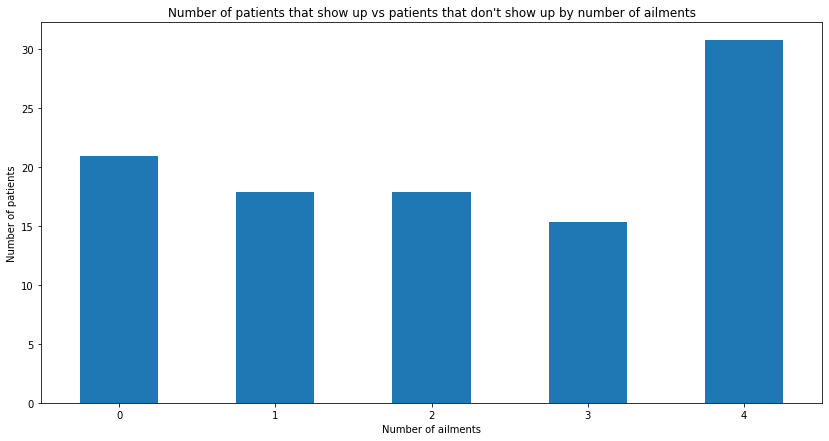

In [239]:
# Plot proportion of patients with ailments that don't show up

result = df_ailm_yes / (df_ailm_yes + df_ailm_no) * 100
result.plot(kind ='bar')
plt.xticks(rotation = 0)
plt.title("Number of patients that show up vs patients that don't show up by number of ailments")
plt.xlabel('Number of ailments')
plt.ylabel('Number of patients')
# Resize chart
plt.rcParams["figure.figsize"] = (14,7)

#### 3. Conclusion

This section computed the proportion of patients the miss theri appointments based on the number of ailments they have. This should provide a better representation of whether the number of ailments does impact no shows

Patients with no ailments seem to be more likely to miss appointments than patients with 1, 2 or 3 ailments. This makes sense as you would expect healthier patients to require less medical attention

Surpringly, it seems like patients with 4 ailments are more likely to miss the appointments, with around 30% of patients that meet that criteria not showing up. It is possible that the patients' physical limitations could be impacting their ability to go to their appointments. However, there are only 13 patients in the entire dataset that match this criteria, which would make this result statistically insignificant as the sample size is far too small.

<a id='conclusions'></a>
## Conclusions

The aim of this report was try to determine whether certain factors influenced whether a patient showed up for a medical appointment or not.   

We limited our research to anwering the following questions:

        1. Which gender is more likely to miss an appointment?

        2. Does the number of days from when a patient schedules an appointment to the actual appointmnet date affect whether s/he shows up?
        
        3. How does the total number of ailments affect a patients decision to miss an appointment

In determing the affect of a patient's gender, we find that approximately 20% of patients do not show up for their scheduled payments.

Females account for 65% of all patients but show up to appointments at a similar rate to male patients - 20.31% of females miss appointments, while 19.97% of males miss their appointments. 

The figures are similar to the total number of patients that miss appointments in the dataset, so there does not appear to be a relationship between a patient’s gender and whether they show up for an appointment.

The number of days between the date an appointment is scheduled and the actual appointment provided more promising insights. We found that a significant number of appointments are scheduled on the same day, with the data heavily skewed to the right. The number of days to an appointment ranged from 0 to 178 days, with 75% of all of appointments taking place within 14 days.Almost half of all appointments take place on the same day that they are scheduled and the average wait time is 9.53 days, with only 8.78% of appointments taking place after 30 days of being scheduled.

Patients that schedule their appointments for the same day seem to be likely to show up, with 91% showing up.Patients seem to be more likely to miss an appointment the longer they wait, with rate of patients showing up dropping to 77% when the wait is between 1 and 3 days. This further falls to 71% between 3 and 10 days and drops to 67% after 10 days.

There appears to be a strong negative correlation between the variable, however correlation does not equal causation so further analysis will be required to determine if a relationship does in fact exist.

We also found that patients with no ailments seem to be more likely to miss appointments than patients with 1, 2 or 3 ailments. This makes sense as you would expect healthier patients to require less medical attention.

Patients with 4 ailments seem to be more likely to miss appointments, with around 30% of patients that meet that criteria not showing up. It is possible that the patients' physical limitations could be impacting their ability to go to their appointments. However, there are only 13 observations in the entire dataset that match this criteria, which would make this result statistically insignificant with the sample size far too small to be conclusive.

#### Limitations
The dataset is very outdated so it may not account for behavioural changes.

Only a limited number of variables were tested. We should aim to test all available factors to see if they have any influence.

The variables were only studied in isolation and ignored the fact that there may be a combination of factors that could provide more accurate predictions.

The research only made use of descriptive statistics to describe the relationships. We would need to employ inferential statistics or machine learning models to make any sort of accurate predication. 

The appointment dates spanned less than two months, which is not enough data to make conclusive predications. This also does not allow us to account for seasonal differences.
